In [1]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


/home/thaott1/miniconda3/envs/pt/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision.models as models
import torchvision
import torch.nn as nn
from torch import Tensor
from torchvision.models.resnet import BasicBlock,Bottleneck
import torch.optim as optim

In [3]:
path = Path('.')

In [4]:
class Unet_ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_input = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=1, stride=1, padding=0, bias=False),
                      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True))
        layers = []
        downsample = nn.Sequential(
          nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        layers.append(Bottleneck(64,64, downsample=downsample))
        for _ in range(0, 4):
            layers.append(Bottleneck(256, 64))
        self.blocks = nn.Sequential(*layers)
        self.conv_end = nn.Sequential( nn.Conv2d(in_channels=256, out_channels=3, kernel_size=1, stride=1, padding=0),
                                  nn.ReLU(inplace=True))
        #Reference source code for initialization of Batch Norm and Conv2d https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x: Tensor) -> Tensor:
        orig = x
        x = self.conv_input(x)
        x = self.blocks(x)
        x = self.conv_end(x)
        x = orig + x
        return x

In [10]:
def imshow(img):
    img = img/2 + 0.5
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    plt.show()

In [11]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

frog


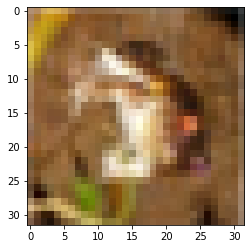

In [14]:
print(classes[label])
imshow(img)

In [15]:
#Sample one image
img, label = data.__getitem__(0)

In [16]:
def add_arrow(img):
    start = 2
    for i in range(start,start+7):
        img[:,i,start+6] = 0
    for i in range(start+5,start+8):
        img[:,start+1,i] = 0
    for i in range(start+4,start+9):
        img[:,start+2,i] = 0
    return img

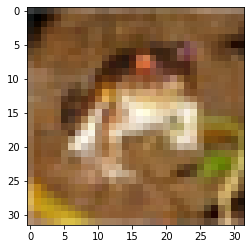

In [17]:
imshow(img)

In [18]:
class arrowedCIFAR(Dataset):
    """Make CIFAR with arrow"""

    def __init__(self, train=True):
        transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.train = train
        if self.train:
            self.cifar = torchvision.datasets.CIFAR10(root = path/'data', download = True, transform=transform, train = True)
        else:
            self.cifar = torchvision.datasets.CIFAR10(root = path/'data', download = True, transform=transform, train = False)
        self.data = []
        self.labels = []
        for i in tqdm(range(len(self.cifar))):
            self.data.append(add_arrow(self.cifar.__getitem__(i)[0])) #Only care about the rotation
            self.labels.append(0)
            for k, angle in enumerate([90, 180, 270]):
                img = add_arrow(self.cifar.__getitem__(i)[0])
                self.data.append(TF.rotate(img, angle))
                self.labels.append(k+1) #Add the rest of labels
            
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [19]:
trainset = arrowedCIFAR(train=True)
testset = arrowedCIFAR(train=False)

Files already downloaded and verified


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:19<00:00, 630.70it/s]


Files already downloaded and verified


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 626.52it/s]


In [20]:
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

In [26]:
def recon_loss(raw_inputs, lens_output):
    loss = nn.MSELoss(reduction = 'sum')
    return loss(raw_inputs,lens_output)

In [27]:
def lens_loss(raw_inputs, lens_output, lambda_term, ssl_loss = None, min_probs = None, final_outputs = None):
    #Adversarial loss: two types
    if ssl_loss:
        total_loss = -ssl_loss + lambda_term*recon_loss(raw_inputs, lens_output)
    else: 
        celoss = nn.CrossEntropyLoss()
        adv_loss = celoss(final_outputs,min_probs)
        total_loss = adv_loss + lambda_term*recon_loss(raw_inputs, lens_output)
    return total_loss

In [28]:
class Resnet_FC4(nn.Module):
    def __init__(self):
        super().__init__()
        #Feature extraction
        res = models.resnet50()
        res.fc = torch.nn.Linear(in_features=2048, out_features=4, bias=True)
        self.res = res
    def forward(self, x: Tensor) -> Tensor:
        x = self.res(x)
        return x

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [30]:
criterion = nn.CrossEntropyLoss(reduction='sum')
sm = nn.Softmax(dim = 1)

In [31]:
torch.cuda.empty_cache()

In [106]:
model1 = Unet_ResNet()
model1.to(device)
model2 = Resnet_FC4()
model2.to(device)

Resnet_FC4(
  (res): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [107]:
#Hyper parameter tuning
lr = 0.001
epochs = 10
lambda_term = 0

In [108]:
optim1 = optim.Adam(model1.parameters(), lr=lr, betas=(0.1, 0.001), eps=1e-07)
optim2 = optim.Adam(model2.parameters(), lr=lr, betas=(0.1, 0.001), eps=1e-07)

In [ ]:
for epoch in range(epochs):
    ssl_losses = 0.0
    lens_losses = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        #Zero gradients out
        optim1.zero_grad()
        optim2.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        lens_output = model1(inputs)
        lens_out_detach = lens_output.detach()
        lens_out_detach.requires_grad_(True) 
        outputs = model2(lens_out_detach)
        #For type 2 of Adversarial loss
        min_probs = torch.argmin(sm(outputs),dim=1)
        ssl_loss = criterion(outputs, labels)
#         l_loss = lens_loss(inputs, lens_out_detach, lambda_term = lambda_term, ssl_loss = ssl_loss, 
#                            min_probs = None, final_outputs = None)
        l_loss = lens_loss(inputs, lens_out_detach, lambda_term = lambda_term, min_probs = min_probs, final_outputs = outputs)
        l_loss.backward(retain_graph=True)
        lens_output.backward(lens_out_detach.grad) #Let the grad of l_loss go thru
        optim2.zero_grad() #Clear out l_loss grad from model2
        ssl_loss.backward()
        #print(model2.res.conv1.weight.grad)
        #print(model1.conv_input[0].weight.grad)
        #Update step
        optim1.step()
        optim2.step()
        ssl_losses += ssl_loss.item()
        lens_losses += l_loss.item()
        if i>0 and i % 50 == 0: 
            print(f'[{epoch}, batch {i}] ssl_loss: {ssl_losses / i:.3f} lens_loss: {lens_losses / i:.3f}')

[0, batch 50] ssl_loss: 478.890 lens_loss: 3.066


## Evaluation of pretext task

In [54]:
batch_size = 256
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)

In [55]:
#Evaluation
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model2(images.to(device))
        predicted = torch.argmax(sm(outputs), dim = 1).cpu()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on test images: {100 * correct // total} %')

Accuracy on test images: 99 %


## Visualization inspection

In [97]:
batch_size = 256
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)

In [98]:
img, label = next(iter(testloader))

In [99]:
model1.eval()
with torch.no_grad():
    img_lensed = model1(img.to(device))
    pred = model2(model1(img.to(device)))
    print(criterion(pred, label.to(device)))

tensor(0.0614, device='cuda:0')


In [100]:
seeing_index = 3

In [101]:
label

tensor([3, 0, 3, 3, 1, 3, 3, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 3, 0, 0, 3,
        2, 1, 1, 3, 2, 0, 1, 1, 3, 2, 2, 0, 0, 3, 0, 3, 0, 3, 2, 2, 0, 3, 1, 0,
        3, 3, 1, 0, 1, 3, 1, 2, 3, 1, 1, 0, 2, 0, 2, 2, 0, 0, 3, 2, 1, 1, 1, 2,
        1, 2, 3, 3, 3, 0, 3, 1, 0, 1, 0, 0, 0, 3, 3, 3, 3, 1, 1, 0, 2, 0, 0, 3,
        2, 0, 0, 2, 0, 0, 0, 3, 2, 1, 0, 1, 1, 3, 2, 3, 0, 1, 0, 3, 1, 2, 1, 2,
        0, 2, 2, 1, 3, 3, 2, 0, 1, 3, 3, 3, 2, 2, 1, 3, 3, 0, 2, 3, 0, 1, 1, 1,
        0, 0, 1, 3, 0, 0, 3, 3, 1, 0, 3, 1, 0, 1, 3, 0, 2, 3, 3, 0, 0, 0, 3, 1,
        3, 0, 2, 2, 2, 0, 0, 3, 2, 0, 3, 0, 3, 3, 1, 0, 3, 3, 2, 2, 3, 1, 1, 0,
        2, 3, 3, 0, 0, 2, 1, 3, 0, 1, 1, 3, 2, 1, 1, 2, 0, 3, 2, 1, 2, 2, 3, 1,
        0, 3, 2, 3, 1, 0, 2, 2, 3, 2, 3, 2, 3, 1, 3, 3, 0, 1, 2, 0, 3, 3, 1, 2,
        2, 1, 0, 2, 1, 0, 2, 3, 2, 0, 1, 0, 1, 3, 1, 3])

In [102]:
torch.argmax(sm(pred), dim = 1)

tensor([3, 0, 3, 3, 1, 3, 3, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 3, 0, 0, 3,
        2, 1, 1, 3, 2, 0, 1, 1, 3, 2, 2, 0, 0, 3, 0, 3, 0, 3, 2, 2, 0, 3, 1, 0,
        3, 3, 1, 0, 1, 3, 1, 2, 3, 1, 1, 0, 2, 0, 2, 2, 0, 0, 3, 2, 1, 1, 1, 2,
        1, 2, 3, 3, 3, 0, 3, 1, 0, 1, 0, 0, 0, 3, 3, 3, 3, 1, 1, 0, 2, 0, 0, 3,
        2, 0, 0, 2, 0, 0, 0, 3, 2, 1, 0, 1, 1, 3, 2, 3, 0, 1, 0, 3, 1, 2, 1, 2,
        0, 2, 2, 1, 3, 3, 2, 0, 1, 3, 3, 3, 2, 2, 1, 3, 3, 0, 2, 3, 0, 1, 1, 1,
        0, 0, 1, 3, 0, 0, 3, 3, 1, 0, 3, 1, 0, 1, 3, 0, 2, 3, 3, 0, 0, 0, 3, 1,
        3, 0, 2, 2, 2, 0, 0, 3, 2, 0, 3, 0, 3, 3, 1, 0, 3, 3, 2, 2, 3, 1, 1, 0,
        2, 3, 3, 0, 0, 2, 1, 3, 0, 1, 1, 3, 2, 1, 1, 2, 0, 3, 2, 1, 2, 2, 3, 1,
        0, 3, 2, 3, 1, 0, 2, 2, 3, 2, 3, 2, 3, 1, 3, 3, 0, 1, 2, 0, 3, 3, 1, 2,
        2, 1, 0, 2, 1, 0, 2, 3, 2, 0, 1, 0, 1, 3, 1, 3], device='cuda:0')

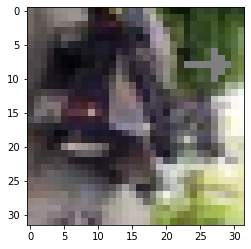

In [103]:
imshow(img[seeing_index].squeeze())

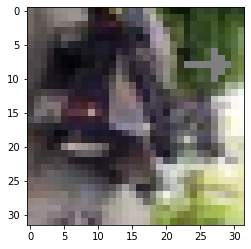

In [104]:
imshow(img_lensed[seeing_index].squeeze().cpu())

In [96]:
k = nn.MSELoss(reduction = 'mean')
k(img[seeing_index],img_lensed[seeing_index].squeeze().cpu())

tensor(0.)

## Coding for the color aberration

In [ ]:
img_zeros = np.zeros((3,32,32))

In [ ]:
img_zeros[2,:,:] = img[2,:,:]
img_zeros[0,:,:] = img[0,:,:]

In [ ]:
move = 1

In [ ]:
img_zeros[1,:,move:32] = img[1,:,0:32-move]
img_zeros[1,:,0:move] = img[1,:,32-move:32] #Shifting up

In [ ]:
img_zeros.shape

In [ ]:
img_zeros = img_zeros/2 + 0.5
plt.imshow(np.transpose(img_zeros, (1, 2, 0)))
plt.show()

In [ ]:
imshow(img)

## Downstream Evaluation

In [ ]:
class Logistic_Net(nn.Module):
    def __init__(self, pretrained_lens_path, pretrained_extractor_path):
        super().__init__()
        lens = torch.load(pretrained_lens_path)
        extractor = torch.load(pretrained_lens_path)
        
        #Frozen all the parameters of both
        
        #Change the FC of extractor 
        
        #Require gradient for the FC

    def forward(self, x: Tensor) -> Tensor:
        x = self.lens(x)
        x = self.extractor(x)
        return x

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

In [ ]:
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

### Downstream training

In [ ]:
#Hyper parameter tuning
lr = 0.001
epochs = 10
criterion = nn.CrossEntropyLoss(reduction='sum')


In [ ]:
model = Logistic_Net()
model.to(device)

In [ ]:
optim = optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(epochs):
    losses = 0.0
    lens_losses = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        optim.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optim.step()
        losses += loss.item()
        if i>0 and i % 50 == 0:
            print(f'[{epoch}, batch {i}] loss: {losses / i:.3f}')

### Downstream evaluation

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

In [ ]:
batch_size = 256
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
sm = nn.Softmax(dim = 1)

In [ ]:
#Evaluation
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        predicted = torch.argmax(sm(outputs), dim = 1).cpu()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on test images: {100 * correct // total} %')